
Training Confusion Matrix:
  [[2565  180]
 [ 225  119]]

Testing Confusion Matrix:
  [[864  59]
 [ 80  27]]

Training Accuracy Score:  0.8688896082874716

Testing Accuracy Score:  0.8650485436893204

Training Precision:  0.3979933110367893

Testing Precision:  0.313953488372093

Training Recall:  0.34593023255813954

Testing Recall:  0.2523364485981308

Train Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.93      0.93      2745
           1       0.40      0.35      0.37       344

    accuracy                           0.87      3089
   macro avg       0.66      0.64      0.65      3089
weighted avg       0.86      0.87      0.86      3089


Test Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.94      0.93       923
           1       0.31      0.25      0.28       107

    accuracy                           0.87      1030
   macro avg       0.61      0.59   

/Users/zhen/Desktop/Bank-Marketing-Data-Analysis/newenv/lib/python3.13/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/zhen/Desktop/Bank-Marketing-Data-Analysis/newenv/lib/python3.13/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/zhen/Desktop/Bank-Marketing-Data-Analysis/newenv/lib/python3.13/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


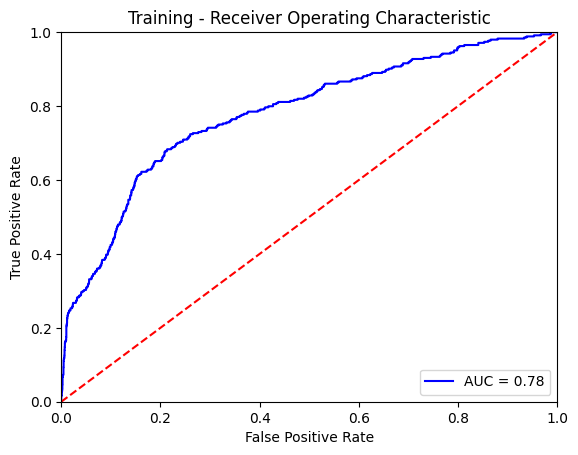

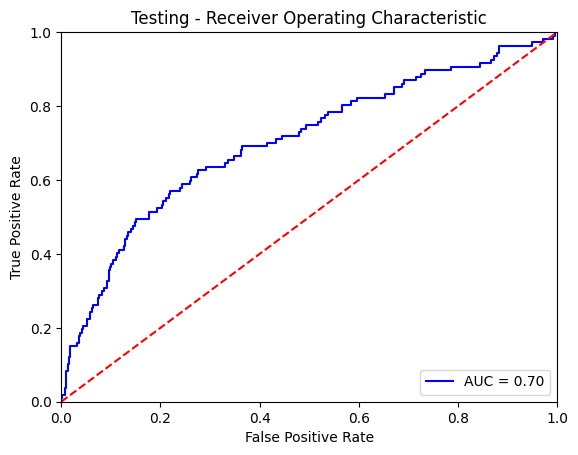

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Apr 26 10:17:51 2018

@author: abinaya
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB, MultinomialNB
#from imblearn.over_sampling import SMOTE
from evaluate_classifier_performance import evaluate_classifier_performance

df_train = pd.read_csv('Data/bank-additional-preprocessed-mode-standardize-train.csv')
df_test = pd.read_csv('Data/bank-additional-preprocessed-mode-standardize-test.csv')
del df_train['Unnamed: 0']
del df_test['Unnamed: 0']


df_train_class = pd.DataFrame(df_train['y'])    
df_train_features = df_train.loc[:, df_train.columns != 'y']

df_test_class = pd.DataFrame(df_test['y'])
df_test_features = df_test.loc[:, df_test.columns != 'y']

'''
### Resampling to balance the dataset
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_sample(df_train_features, df_train_class)
df_train_features = pd.DataFrame(X_res, columns=df_train_features.columns)
df_train_class = pd.DataFrame(y_res, columns=df_train_class.columns)
'''
### separate Continuous and Multinmoial Features
continuous_features = ['age', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

df_train_features_cont = df_train_features.loc[:,df_train_features.columns.isin(continuous_features)]
df_train_features_cate =  df_train_features.loc[:,~df_train_features.columns.isin(continuous_features)]

df_test_features_cont = df_test_features.loc[:, df_test_features.columns.isin(continuous_features)]
df_test_features_cate =  df_test_features.loc[:,~df_test_features.columns.isin(continuous_features)]

### Fit Gaussian NB model
gaussian_nb = GaussianNB()
gaussian_nb.fit(df_train_features_cont, df_train_class)

gaussian_predicted_prob_train = gaussian_nb.predict_proba(df_train_features_cont)
gaussian_predicted_prob_test = gaussian_nb.predict_proba(df_test_features_cont)

### Fit Multinomial NB model
multinomial_nb = MultinomialNB()
multinomial_nb.fit(df_train_features_cate, df_train_class)

multinomial_predicted_prob_train = multinomial_nb.predict_proba(df_train_features_cate)
multinomial_predicted_prob_test = multinomial_nb.predict_proba(df_test_features_cate)

### Fit probabilites on Gaussian again

combined_predicted_prob_train = np.vstack([gaussian_predicted_prob_train[:,1],multinomial_predicted_prob_train[:,1]]).T
combined_predicted_prob_test = np.vstack([gaussian_predicted_prob_test[:,1],multinomial_predicted_prob_test[:,1]]).T

gaussian_nb_final = GaussianNB()
gaussian_nb_final.fit(combined_predicted_prob_train, df_train_class)

predicted_train = gaussian_nb_final.predict(combined_predicted_prob_train)
predicted_test = gaussian_nb_final.predict(combined_predicted_prob_test)

predicted_prob_train = gaussian_nb_final.predict_proba(combined_predicted_prob_train)
predicted_prob_test = gaussian_nb_final.predict_proba(combined_predicted_prob_test)

evaluate_classifier_performance(df_train_class, predicted_train, predicted_prob_train, df_test_class, predicted_test, predicted_prob_test, 'y')
